In [20]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn import preprocessing
from sklearn.compose import make_column_transformer

# sns.set()

random_state = 123_456
np.random.seed(random_state)

In [21]:
df = pd.read_csv('fuel-prices/all_features_combined.csv', index_col='date', dtype={'price': np.int32, 
                 'tapis_oil_price': np.int32, 'national_avg_price': np.int32}, parse_dates=True)
df.set_index(pd.date_range(min(df.index), periods=df.shape[0], freq='D'), inplace=True, verify_integrity=True)

In [22]:
df['price_t_plus_1'] = df.price.shift(-1)
df.price_t_plus_1.fillna(method='ffill', inplace=True)
df.price_t_plus_1 = df.price_t_plus_1.astype('int32')

df['tapis_oil_price_t_minus_10'] = df.tapis_oil_price.shift(10)
df.tapis_oil_price_t_minus_10.fillna(method='bfill', inplace=True)
df.tapis_oil_price_t_minus_10 = df.tapis_oil_price_t_minus_10.astype('int32')
  
features = ['price_t_plus_1','tapis_oil_price_t_minus_10']
df = df[features]
df

price_t_plus_1  tapis_oil_price_t_minus_10
2017-01-01            1436                        5863
2017-01-02            1409                        5863
2017-01-03            1542                        5863
2017-01-04            1582                        5863
2017-01-05            1529                        5863
...                    ...                         ...
2019-12-27            1589                        7084
2019-12-28            1579                        7103
2019-12-29            1602                        7159
2019-12-30            1609                        7198
2019-12-31            1609                        7177

[1095 rows x 2 columns]

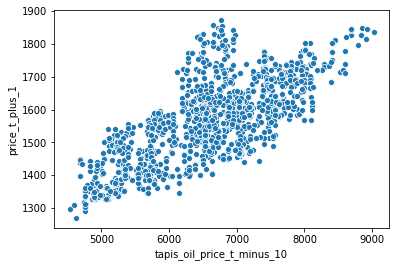

In [23]:
sns.scatterplot(x='tapis_oil_price_t_minus_10', y='price_t_plus_1', data=df)
plt.show()

In [24]:
ct = make_column_transformer((preprocessing.PowerTransformer('box-cox', standardize=False), features))
result = ct.fit_transform(df)
df_temp = pd.DataFrame(result, columns=features, index=df.index)

for column in features:
    del df[column]

df = df.merge(df_temp, left_index=True, right_index=True, validate='one_to_one')
df

price_t_plus_1  tapis_oil_price_t_minus_10
2017-01-01      209.583257                20197.863261
2017-01-02      206.861028                20197.863261
2017-01-03      220.118182                20197.863261
2017-01-04      224.033648                20197.863261
2017-01-05      218.838769                20197.863261
...                    ...                         ...
2019-12-27      224.715621                25152.616771
2019-12-28      223.741082                25230.867338
2019-12-29      225.979629                25461.694723
2019-12-30      226.658906                25622.619998
2019-12-31      226.658906                25535.950583

[1095 rows x 2 columns]

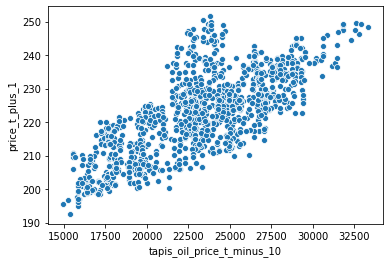

In [25]:
sns.scatterplot(x='tapis_oil_price_t_minus_10', y='price_t_plus_1', data=df)
plt.show()

In [26]:
kmeans = KMeans(n_clusters=3, random_state=random_state)

In [27]:
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123456, tol=0.0001, verbose=0)

In [28]:
kmeans.labels_

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [29]:
X = df.values
X

array([[  209.58325653, 20197.86326064],
       [  206.8610277 , 20197.86326064],
       [  220.1181824 , 20197.86326064],
       ...,
       [  225.9796291 , 25461.69472277],
       [  226.65890579, 25622.61999793],
       [  226.65890579, 25535.95058294]])

In [30]:
df = pd.concat((df, pd.Series(kmeans.labels_, index=df.index, name='tapis_oil_cluster_label')), axis=1)
# df_new.rename(columns={'0':'label'}, inplace=True)
# df_new.info()

In [31]:
# my_list = list()

# for i in range(len(kmeans.labels_)):
#     my_dict = dict(f1=X[i][0], f2=X[i][1], label=kmeans.labels_[i])
#     my_list.append(my_dict)
#     print(X[i][0])
# my_list
# df = pd.DataFrame(my_list)
# df

In [32]:
df

price_t_plus_1  tapis_oil_price_t_minus_10  \
2017-01-01      209.583257                20197.863261   
2017-01-02      206.861028                20197.863261   
2017-01-03      220.118182                20197.863261   
2017-01-04      224.033648                20197.863261   
2017-01-05      218.838769                20197.863261   
...                    ...                         ...   
2019-12-27      224.715621                25152.616771   
2019-12-28      223.741082                25230.867338   
2019-12-29      225.979629                25461.694723   
2019-12-30      226.658906                25622.619998   
2019-12-31      226.658906                25535.950583   

            tapis_oil_cluster_label  
2017-01-01                        1  
2017-01-02                        1  
2017-01-03                        1  
2017-01-04                        1  
2017-01-05                        1  
...                             ...  
2019-12-27                        0  
2019-12-28                        0  
2019-12-29                        0  
2019-12-30                        0  
2019-12-31                        0  

[1095 rows x 3 columns]

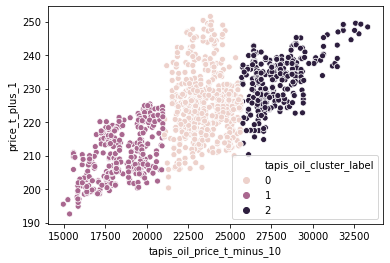

In [33]:
_ = sns.scatterplot(x='tapis_oil_price_t_minus_10', y='price_t_plus_1', data=df, hue='tapis_oil_cluster_label')

In [34]:
metrics.silhouette_score(X, kmeans.labels_, metric='euclidean', sample_size=None)

0.6160887408695674

/usr/local/Cellar/jupyterlab/1.2.4/libexec/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/Cellar/jupyterlab/1.2.4/libexec/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


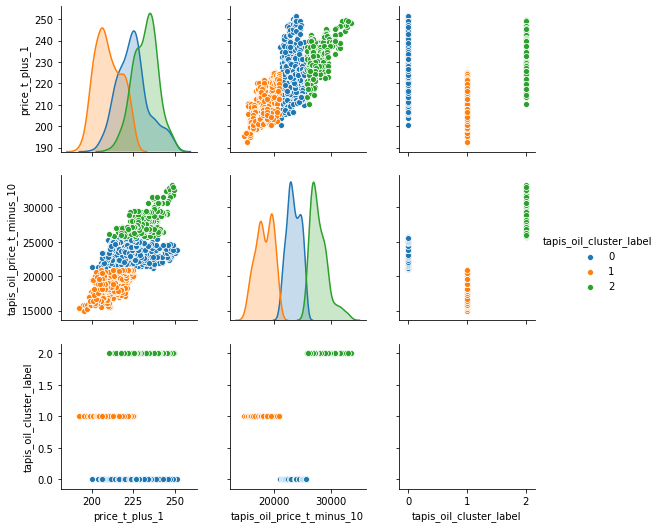

In [35]:
_ = sns.pairplot(df, hue='tapis_oil_cluster_label')

In [36]:
range_n_clusters = [2, 3, 4, 5, 6]

For n_clusters = 2 The average silhouette_score is : 0.5807099785985608
For n_clusters = 3 The average silhouette_score is : 0.6160887408695674
For n_clusters = 4 The average silhouette_score is : 0.555009685008994
For n_clusters = 5 The average silhouette_score is : 0.5565984492496826
For n_clusters = 6 The average silhouette_score is : 0.587455143536419


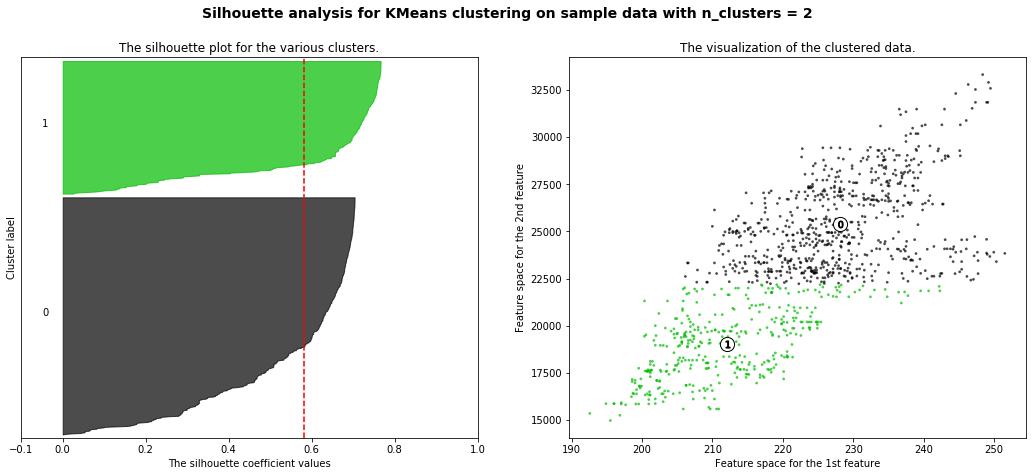

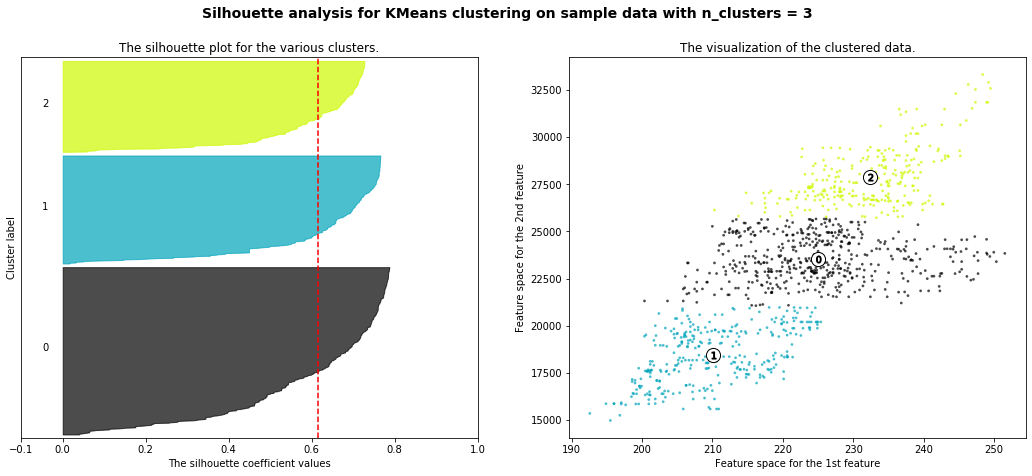

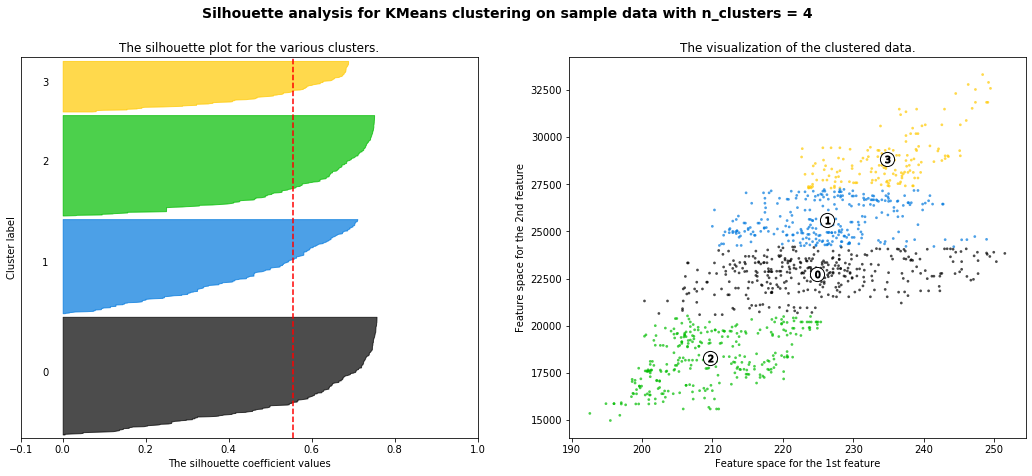

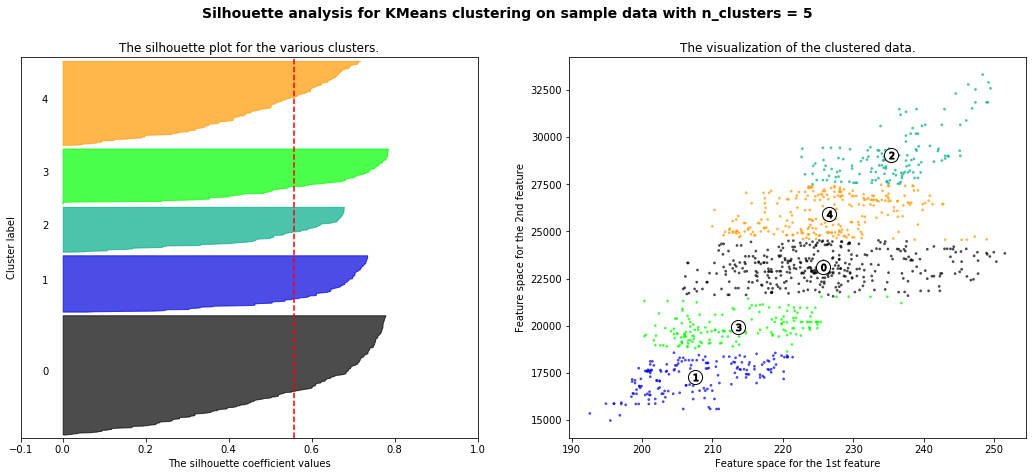

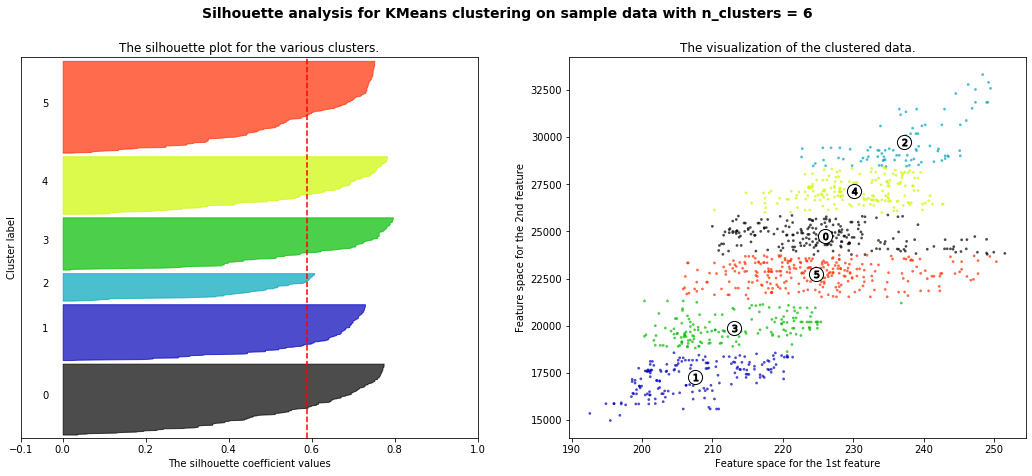

In [37]:
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [38]:
df.to_csv('other-features/tapis_oil_cluster_2017-2019.csv',index_label='date')